In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shap

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from shapely.wkt import load
import pickle
import clean_utils
from importlib import reload
from matplotlib.colors import ListedColormap
import seaborn as sns

from scipy import stats
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier, Pool, cv
from hyperopt import fmin, hp, tpe, STATUS_OK, STATUS_FAIL, Trials

In [2]:
df4 = pd.read_csv('cleaned_rhna4_data.csv', low_memory=False)
df5 = pd.read_csv('cleaned_rhna5_data.csv', low_memory=False)

In [3]:
scoring = ('accuracy', 'precision_weighted', 'f1_weighted', 'recall_weighted')

In [13]:
train = df4.drop(
    ['MapBlkLot_Master'], axis=1
)

In [14]:
train.nunique().max()

99567

In [15]:
pd.get_dummies(train).shape

(153204, 433)

In [101]:
train['inInventory'].sum()

4392

### Remove illegal values

In [29]:
train.loc[train.FBA < 0, 'FBA'] = np.nan

In [32]:
train.loc[train.ROOMS < 0, 'ROOMS'] = np.nan

In [31]:
# 2023 is actually to late.
train.loc[train.YRBLT > 2023, 'YRBLT'] = np.nan

In [34]:
train.Developed = train.Developed > 0

# Propensity Score

### RFC Propensity Score Model

In [8]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc_pipe = Pipeline(
    [
        ("rfc", rfc),
    ]
)

rfc_param_grid = [
    {
        'rfc__max_features': ['log2', 'sqrt'],
        'rfc__min_samples_split': stats.randint(2, 20),
        'rfc__min_samples_leaf': stats.randint(1, 10),
        'rfc__max_depth': stats.randint(5, 15),
        'rfc__ccp_alpha': stats.uniform(0, .25)
    }
]

rfc_pscore = RandomizedSearchCV(rfc_pipe,
                                n_iter=10,
                                n_jobs=-1,
                                param_distributions=rfc_param_grid,
                                verbose=1,
                                random_state=0)

In [9]:
%%time
train_dummy_X = train_dummy.drop(['inInventory', 'Developed'], axis=1)
rfc_pscore.fit(train_dummy_X, train_dummy['inInventory'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 17 s
Wall time: 2min 22s


RandomizedSearchCV(estimator=Pipeline(steps=[('rfc',
                                              RandomForestClassifier(class_weight='balanced'))]),
                   n_jobs=-1,
                   param_distributions=[{'rfc__ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001EBBBB83550>,
                                         'rfc__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EBE766E6A0>,
                                         'rfc__max_features': ['log2', 'sqrt'],
                                         'rfc__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EBE7659070>,
                                         'rfc__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EBBBB60A00>}],
                   random_state=0, verbose=1)

In [10]:
rfc_pscore.best_params_

{'rfc__ccp_alpha': 0.2030421821938733,
 'rfc__max_depth': 13,
 'rfc__max_features': 'sqrt',
 'rfc__min_samples_leaf': 6,
 'rfc__min_samples_split': 15}

In [11]:
rfc_pscore.best_score_

0.9291678286385959

In [12]:
propensity_score_model = pd.DataFrame(rfc_pscore.cv_results_)

In [13]:
propensity_score_model.to_csv('propensity_score_model_results.csv', index=False)

In [14]:
propensity_score_model.sort_values('mean_fit_time', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__ccp_alpha,param_rfc__max_depth,param_rfc__max_features,param_rfc__min_samples_leaf,param_rfc__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,77.283968,2.981698,0.378664,0.025494,0.203042,13,sqrt,6,15,"{'rfc__ccp_alpha': 0.2030421821938733, 'rfc__m...",0.885135,0.971341,0.971341,0.890031,0.927991,0.929168,0.037494,1
4,56.992739,1.991733,0.414409,0.017406,0.084349,9,sqrt,1,7,"{'rfc__ccp_alpha': 0.0843490401043171, 'rfc__m...",0.734136,0.972255,0.905764,0.873547,0.900669,0.877274,0.078591,6
7,53.793698,0.413690,0.176495,0.020517,0.145505,14,sqrt,1,12,"{'rfc__ccp_alpha': 0.14550494801877678, 'rfc__...",0.359773,0.974115,0.924501,0.890031,0.927991,0.815282,0.229319,8
1,51.093425,1.613310,0.397752,0.026533,0.211813,8,sqrt,3,6,"{'rfc__ccp_alpha': 0.21181293469603135, 'rfc__...",0.885135,0.028659,0.971341,0.971341,0.927991,0.756893,0.365519,10
6,51.021512,0.961105,0.356265,0.037525,0.11537,8,sqrt,8,2,"{'rfc__ccp_alpha': 0.11536984056323296, 'rfc__...",0.585618,0.970982,0.915035,0.882002,0.900375,0.850802,0.135884,7


In [98]:
print(classification_report(train_dummy['inInventory'], rfc_pscore.predict(train_dummy_X), digits=5))

              precision    recall  f1-score   support

       False    0.99048   0.92691   0.95764    148790
        True    0.21981   0.69811   0.33435      4389

    accuracy                        0.92035    153179
   macro avg    0.60515   0.81251   0.64600    153179
weighted avg    0.96840   0.92035   0.93978    153179



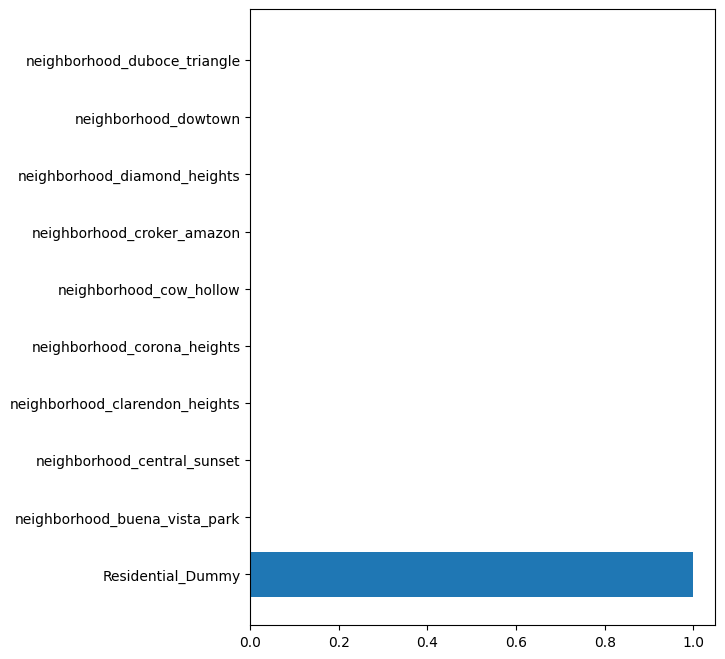

In [93]:
importances = rfc_pscore.best_estimator_.steps[0][1].feature_importances_
ft_imp = pd.Series(importances,
                   index=train_dummy_X.columns)
ft_imp = ft_imp.sort_values(ascending=False)
plt.figure(figsize=(6, 8))
plt.barh(ft_imp.index[:10], ft_imp[:10])
plt.show()

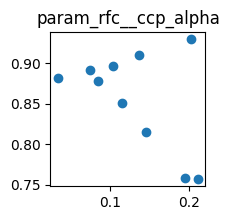

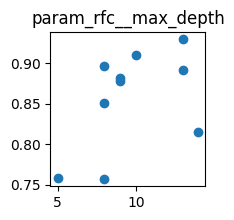

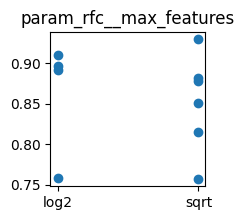

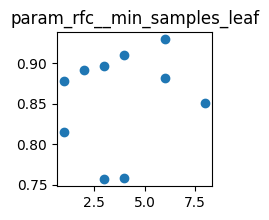

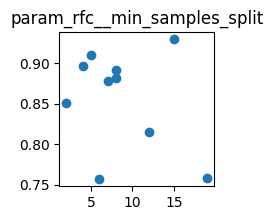

In [17]:
for c in propensity_score_model.columns:
    if c.startswith('param_'):
        plt.figure(figsize=(2, 2))
        plt.title(c)
        plt.scatter(propensity_score_model[c],
                    propensity_score_model['mean_test_score'])
        plt.show()

### Catboost Propensity Score Model

In [35]:
X_ps = train.drop(['Developed', 'inInventory'], axis=1)
y_ps = train['inInventory']

In [36]:
categories = [X_ps.columns[i] for i, d in enumerate(X_ps.dtypes) if d == 'object']
X_ps[categories] = X_ps[categories].astype(str)

In [37]:
trainX_ps, validX_ps, trainY_ps, validY_ps = train_test_split(X_ps,
                                                              y_ps, 
                                                              train_size=0.8, 
                                                              random_state=42)

train_dataset_ps = Pool(data=trainX_ps,
                        label=trainY_ps,
                        cat_features = categories)

eval_dataset_ps = Pool(data=validX_ps,
                       label=validY_ps, 
                       cat_features = categories)

In [38]:
train_pool_ps = Pool(data=X_ps, label=y_ps, has_header=True, 
                     cat_features = categories)

In [39]:
def hyperopt_objective(params):

    model = CatBoostClassifier(**params, random_seed=42)
    model.fit(train_dataset_ps, verbose=10, eval_set=eval_dataset_ps, early_stopping_rounds=10)
    model.predict_proba(validX_ps)
    cv_data = cv(
        params=params,
        pool=train_pool_ps,
        fold_count=5,
        shuffle=True,
        partition_random_seed=0,
        stratified=False,
        verbose=False,
        early_stopping_rounds=10
    )
    
    loss = cv_data['test-Logloss-mean'].min()
    print(loss)
    return loss

# We initiate a Trial object to keep track of search results and we set a hyperparameter space
trials = Trials()

space = {
    "iterations": 100,
     "loss_function": "Logloss",
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'depth': hp.randint('depth', 3, 15),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 15),
    'border_count': hp.randint('border_count', 2, 50),
    'boosting_type': 'Plain'
}

best = fmin(hyperopt_objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            rstate=np.random.default_rng(42))

  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]0:	learn: 0.1802758	test: 0.1829300	best: 0.1829300 (0)	total: 199ms	remaining: 19.7s
10:	learn: 0.0609779	test: 0.0689649	best: 0.0689649 (10)	total: 715ms	remaining: 5.78s
20:	learn: 0.0571154	test: 0.0668383	best: 0.0668383 (20)	total: 1.23s	remaining: 4.63s
30:	learn: 0.0555907	test: 0.0660929	best: 0.0660929 (30)	total: 1.69s	remaining: 3.75s
40:	learn: 0.0532401	test: 0.0652571	best: 0.0652417 (39)	total: 2.17s	remaining: 3.12s
50:	learn: 0.0507999	test: 0.0647184	best: 0.0647184 (50)	total: 2.65s	remaining: 2.54s
60:	learn: 0.0485902	test: 0.0637805	best: 0.0637579 (59)	total: 3.12s	remaining: 2s
70:	learn: 0.0475946	test: 0.0633061	best: 0.0633061 (70)	total: 3.59s	remaining: 1.46s
80:	learn: 0.0459459	test: 0.0631174	best: 0.0631174 (80)	total: 4.07s	remaining: 955ms
90:	learn: 0.0446248	test: 0.0630988	best: 0.0629815 (83)	total: 4.53s	remaining: 448ms
99:	le

10:	learn: 0.0560117	test: 0.0681067	best: 0.0681067 (10)	total: 955ms	remaining: 7.73s
20:	learn: 0.0505648	test: 0.0661156	best: 0.0661156 (20)	total: 1.79s	remaining: 6.72s
30:	learn: 0.0457123	test: 0.0652261	best: 0.0651927 (24)	total: 2.59s	remaining: 5.77s
40:	learn: 0.0427677	test: 0.0646997	best: 0.0646997 (40)	total: 3.38s	remaining: 4.87s
50:	learn: 0.0385814	test: 0.0649193	best: 0.0645576 (44)	total: 4.21s	remaining: 4.04s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.06455761336
bestIteration = 44

Shrink model to first 45 iterations.
Training on fold [0/5]

bestTest = 0.05776509442
bestIteration = 29

Training on fold [1/5]

bestTest = 0.06396427675
bestIteration = 45

Training on fold [2/5]

bestTest = 0.06070048389
bestIteration = 37

Training on fold [3/5]

bestTest = 0.06092134349
bestIteration = 29

Training on fold [4/5]

bestTest = 0.06479314495
bestIteration = 25

0.06180447038105219                                                           

In [40]:
best

{'border_count': 30,
 'depth': 10,
 'l2_leaf_reg': 3.971039637906693,
 'learning_rate': 0.20785105842836982}

In [41]:
pickle.dump(trials, open("my_trials_pscore.pkl", "wb"))

with open("my_trials_pscore.pkl", "rb") as f:
    object = pickle.load(f)

df_ps_trials = pd.DataFrame(object)
df_ps_trials.to_csv(r'catboost_results_pscore.csv')

In [42]:
catboostFinalPs = CatBoostClassifier(**best, loss_function='Logloss')

In [43]:
# We fit model using our train pool
catboostFinalPs.fit(train_dataset_ps)

0:	learn: 0.3552081	total: 167ms	remaining: 2m 47s
1:	learn: 0.2187355	total: 312ms	remaining: 2m 35s
2:	learn: 0.1349419	total: 466ms	remaining: 2m 34s
3:	learn: 0.1006212	total: 634ms	remaining: 2m 37s
4:	learn: 0.0841858	total: 793ms	remaining: 2m 37s
5:	learn: 0.0771262	total: 956ms	remaining: 2m 38s
6:	learn: 0.0726373	total: 1.12s	remaining: 2m 38s
7:	learn: 0.0688937	total: 1.28s	remaining: 2m 38s
8:	learn: 0.0668907	total: 1.44s	remaining: 2m 38s
9:	learn: 0.0642176	total: 1.59s	remaining: 2m 37s
10:	learn: 0.0621686	total: 1.75s	remaining: 2m 37s
11:	learn: 0.0607114	total: 1.92s	remaining: 2m 37s
12:	learn: 0.0596177	total: 2.06s	remaining: 2m 36s
13:	learn: 0.0584384	total: 2.22s	remaining: 2m 36s
14:	learn: 0.0578772	total: 2.38s	remaining: 2m 36s
15:	learn: 0.0571992	total: 2.53s	remaining: 2m 35s
16:	learn: 0.0566575	total: 2.7s	remaining: 2m 36s
17:	learn: 0.0559094	total: 2.86s	remaining: 2m 35s
18:	learn: 0.0553828	total: 3.02s	remaining: 2m 35s
19:	learn: 0.0552142	to

158:	learn: 0.0317785	total: 25.9s	remaining: 2m 16s
159:	learn: 0.0317000	total: 26.1s	remaining: 2m 16s
160:	learn: 0.0315563	total: 26.2s	remaining: 2m 16s
161:	learn: 0.0315389	total: 26.4s	remaining: 2m 16s
162:	learn: 0.0314829	total: 26.6s	remaining: 2m 16s
163:	learn: 0.0313450	total: 26.7s	remaining: 2m 16s
164:	learn: 0.0313241	total: 26.9s	remaining: 2m 16s
165:	learn: 0.0313238	total: 27s	remaining: 2m 15s
166:	learn: 0.0312663	total: 27.2s	remaining: 2m 15s
167:	learn: 0.0311478	total: 27.4s	remaining: 2m 15s
168:	learn: 0.0310228	total: 27.5s	remaining: 2m 15s
169:	learn: 0.0309526	total: 27.7s	remaining: 2m 15s
170:	learn: 0.0308804	total: 27.9s	remaining: 2m 15s
171:	learn: 0.0306727	total: 28.1s	remaining: 2m 15s
172:	learn: 0.0306694	total: 28.2s	remaining: 2m 14s
173:	learn: 0.0305205	total: 28.4s	remaining: 2m 14s
174:	learn: 0.0304821	total: 28.6s	remaining: 2m 14s
175:	learn: 0.0304800	total: 28.7s	remaining: 2m 14s
176:	learn: 0.0304444	total: 28.9s	remaining: 2m

315:	learn: 0.0217628	total: 51.4s	remaining: 1m 51s
316:	learn: 0.0217476	total: 51.6s	remaining: 1m 51s
317:	learn: 0.0217188	total: 51.8s	remaining: 1m 51s
318:	learn: 0.0217179	total: 52s	remaining: 1m 50s
319:	learn: 0.0216673	total: 52.1s	remaining: 1m 50s
320:	learn: 0.0216656	total: 52.3s	remaining: 1m 50s
321:	learn: 0.0216312	total: 52.5s	remaining: 1m 50s
322:	learn: 0.0216307	total: 52.6s	remaining: 1m 50s
323:	learn: 0.0216213	total: 52.8s	remaining: 1m 50s
324:	learn: 0.0215901	total: 52.9s	remaining: 1m 49s
325:	learn: 0.0215857	total: 53.1s	remaining: 1m 49s
326:	learn: 0.0215475	total: 53.3s	remaining: 1m 49s
327:	learn: 0.0212718	total: 53.4s	remaining: 1m 49s
328:	learn: 0.0212598	total: 53.6s	remaining: 1m 49s
329:	learn: 0.0212215	total: 53.7s	remaining: 1m 49s
330:	learn: 0.0211772	total: 53.9s	remaining: 1m 48s
331:	learn: 0.0211547	total: 54.1s	remaining: 1m 48s
332:	learn: 0.0210764	total: 54.2s	remaining: 1m 48s
333:	learn: 0.0208062	total: 54.4s	remaining: 1m

470:	learn: 0.0160773	total: 1m 16s	remaining: 1m 25s
471:	learn: 0.0160491	total: 1m 16s	remaining: 1m 25s
472:	learn: 0.0159773	total: 1m 16s	remaining: 1m 25s
473:	learn: 0.0158865	total: 1m 16s	remaining: 1m 25s
474:	learn: 0.0158711	total: 1m 17s	remaining: 1m 25s
475:	learn: 0.0158572	total: 1m 17s	remaining: 1m 25s
476:	learn: 0.0158557	total: 1m 17s	remaining: 1m 24s
477:	learn: 0.0158552	total: 1m 17s	remaining: 1m 24s
478:	learn: 0.0158551	total: 1m 17s	remaining: 1m 24s
479:	learn: 0.0158550	total: 1m 17s	remaining: 1m 24s
480:	learn: 0.0158425	total: 1m 18s	remaining: 1m 24s
481:	learn: 0.0157935	total: 1m 18s	remaining: 1m 24s
482:	learn: 0.0157892	total: 1m 18s	remaining: 1m 23s
483:	learn: 0.0157883	total: 1m 18s	remaining: 1m 23s
484:	learn: 0.0156823	total: 1m 18s	remaining: 1m 23s
485:	learn: 0.0156817	total: 1m 18s	remaining: 1m 23s
486:	learn: 0.0155145	total: 1m 19s	remaining: 1m 23s
487:	learn: 0.0154502	total: 1m 19s	remaining: 1m 23s
488:	learn: 0.0154392	total:

625:	learn: 0.0123839	total: 1m 42s	remaining: 1m
626:	learn: 0.0123229	total: 1m 42s	remaining: 1m
627:	learn: 0.0123070	total: 1m 42s	remaining: 1m
628:	learn: 0.0122527	total: 1m 42s	remaining: 1m
629:	learn: 0.0122228	total: 1m 42s	remaining: 1m
630:	learn: 0.0122098	total: 1m 42s	remaining: 1m
631:	learn: 0.0121940	total: 1m 43s	remaining: 1m
632:	learn: 0.0121936	total: 1m 43s	remaining: 59.9s
633:	learn: 0.0121919	total: 1m 43s	remaining: 59.7s
634:	learn: 0.0121915	total: 1m 43s	remaining: 59.5s
635:	learn: 0.0121835	total: 1m 43s	remaining: 59.4s
636:	learn: 0.0121780	total: 1m 43s	remaining: 59.2s
637:	learn: 0.0121303	total: 1m 44s	remaining: 59s
638:	learn: 0.0121296	total: 1m 44s	remaining: 58.9s
639:	learn: 0.0121246	total: 1m 44s	remaining: 58.7s
640:	learn: 0.0121246	total: 1m 44s	remaining: 58.5s
641:	learn: 0.0121229	total: 1m 44s	remaining: 58.4s
642:	learn: 0.0120735	total: 1m 44s	remaining: 58.2s
643:	learn: 0.0120689	total: 1m 45s	remaining: 58.1s
644:	learn: 0.01

783:	learn: 0.0093120	total: 2m 8s	remaining: 35.4s
784:	learn: 0.0092989	total: 2m 8s	remaining: 35.3s
785:	learn: 0.0092819	total: 2m 8s	remaining: 35.1s
786:	learn: 0.0092103	total: 2m 9s	remaining: 34.9s
787:	learn: 0.0092026	total: 2m 9s	remaining: 34.8s
788:	learn: 0.0091603	total: 2m 9s	remaining: 34.6s
789:	learn: 0.0091542	total: 2m 9s	remaining: 34.5s
790:	learn: 0.0091221	total: 2m 9s	remaining: 34.3s
791:	learn: 0.0091219	total: 2m 9s	remaining: 34.1s
792:	learn: 0.0091203	total: 2m 10s	remaining: 34s
793:	learn: 0.0091179	total: 2m 10s	remaining: 33.8s
794:	learn: 0.0091102	total: 2m 10s	remaining: 33.6s
795:	learn: 0.0091072	total: 2m 10s	remaining: 33.5s
796:	learn: 0.0091068	total: 2m 10s	remaining: 33.3s
797:	learn: 0.0091049	total: 2m 11s	remaining: 33.2s
798:	learn: 0.0091000	total: 2m 11s	remaining: 33s
799:	learn: 0.0090938	total: 2m 11s	remaining: 32.9s
800:	learn: 0.0090913	total: 2m 11s	remaining: 32.7s
801:	learn: 0.0090901	total: 2m 11s	remaining: 32.6s
802:	l

939:	learn: 0.0070179	total: 2m 35s	remaining: 9.95s
940:	learn: 0.0069973	total: 2m 36s	remaining: 9.79s
941:	learn: 0.0069962	total: 2m 36s	remaining: 9.62s
942:	learn: 0.0069890	total: 2m 36s	remaining: 9.46s
943:	learn: 0.0069787	total: 2m 36s	remaining: 9.29s
944:	learn: 0.0069779	total: 2m 36s	remaining: 9.13s
945:	learn: 0.0069727	total: 2m 36s	remaining: 8.96s
946:	learn: 0.0069665	total: 2m 37s	remaining: 8.79s
947:	learn: 0.0069626	total: 2m 37s	remaining: 8.63s
948:	learn: 0.0069626	total: 2m 37s	remaining: 8.46s
949:	learn: 0.0069591	total: 2m 37s	remaining: 8.3s
950:	learn: 0.0069591	total: 2m 37s	remaining: 8.13s
951:	learn: 0.0069272	total: 2m 37s	remaining: 7.96s
952:	learn: 0.0069178	total: 2m 38s	remaining: 7.79s
953:	learn: 0.0068874	total: 2m 38s	remaining: 7.63s
954:	learn: 0.0068874	total: 2m 38s	remaining: 7.46s
955:	learn: 0.0068775	total: 2m 38s	remaining: 7.29s
956:	learn: 0.0068658	total: 2m 38s	remaining: 7.13s
957:	learn: 0.0068654	total: 2m 38s	remaining: 

In [44]:
# Get predicted classes for training and validation set
preds_class_pscore = catboostFinalPs.predict(validX_ps)
preds_class_train_pscore = catboostFinalPs.predict(trainX_ps)
preds_class_train_pscore = [c == 'True' for c in preds_class_train_pscore]
preds_class_pscore = [c == 'True' for c in preds_class_pscore]

In [45]:
print(classification_report(validY_ps, preds_class_pscore, digits=5))


              precision    recall  f1-score   support

       False    0.98576   0.99401   0.98987     29737
        True    0.72824   0.52765   0.61193       904

    accuracy                        0.98026     30641
   macro avg    0.85700   0.76083   0.80090     30641
weighted avg    0.97816   0.98026   0.97872     30641



In [54]:
# set color palette for all plots
cmap = sns.color_palette("Blues", as_cmap=True)
colors = {'GALAXY': cmap(0.2),
          'STAR': cmap(0.6),
          'QSO': cmap(0.99)}
# make color map for shapley values plot
my_cmap = ListedColormap([cmap(0.6), cmap(0.99)])

In [60]:
validX_ps.sample(100)

,Historic,Residential_Dummy,Envelope_1000,Upzone_Ratio,zp_OfficeComm,zp_DensRestMulti,zp_FormBasedMulti,zp_PDRInd,zp_Public,zp_Redev,...,RP1EXMVL1,RECURRSALD,RP1FXTVAL,RP1IMPVAL,RP1LNDVAL,RP1PPTVAL,general_use_code,hasBMR,neighborhood,district
38650,0,1,2.000000,0.788022,0,0,0,0,0,0,...,0,50915,0,448800,673200,0,SRES,False,outer_sunset,district2
94995,0,1,1.000000,0.326797,0,0,0,0,0,0,...,0,40916,0,244494,572220,0,MRES,False,inner_ission,district9
57486,0,1,1.000000,0.313087,0,0,0,0,0,0,...,0,911018,0,461959,461959,0,SRES,False,clarendon_heights,district5
7064,1,1,1.000000,0.438628,0,0,0,0,0,0,...,7000,0,0,47749,66378,0,SRES,False,marina,district7
107829,0,1,1.820298,0.802601,0,0,0,0,0,0,...,0,0,0,93554,43741,0,SRES,False,yerba_buena,district9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41065,0,1,6.249998,0.652128,0,1,0,0,0,0,...,7000,0,0,957567,541249,0,COMM,False,inner_sunset,district2
149403,0,1,1.000000,0.414373,0,0,0,0,0,0,...,7000,0,0,26709,18606,0,SRES,False,glen_park,district5
146489,0,0,3.340507,0.521954,0,1,0,0,0,0,...,0,0,0,53950,141726,0,COMR,False,lakeside,district3
50109,0,1,1.000000,0.443236,0,0,0,0,0,0,...,0,0,0,38439,27746,0,SRES,False,central_sunset,district2


In [ ]:
%%time
explainer = shap.TreeExplainer(catboostFinalPs)
shap_values = explainer.shap_values(validX_ps)

In [68]:
plt.clf()
shap.summary_plot(shap_values,
                  validX_ps,
                  feature_names=validX_ps.columns,
                  color=my_cmap, 
                  max_display=10,
                  class_names=['Built', 'Not'],
                  show=False)  # show = False in order to save the figure properly
# plt.show()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./figures/shapleyvals_ps.png', bbox_inches="tight")

In [98]:
ftimp_ps = pd.DataFrame({'feature_importance': catboostFinalPs.get_feature_importance(train_dataset_ps), 
                         'feature_names': trainX_ps.columns})

In [99]:
ftimp_ps = ftimp_ps.sort_values(by=['feature_importance'], ascending=False)

In [100]:
plt.clf()
ftimp_ps.head(20).plot(kind='barh', x='feature_names', y='feature_importance')
plt.savefig('./figures/ftimp_ps.png', bbox_inches="tight")

### Outcome Regression

Only 2.87% of the dataset was selected in the site inventory.

#### RFC

In [71]:
rfc_best_outcome = RandomizedSearchCV(rfc_pipe,
                                      n_iter=10,
                                      n_jobs=-1,
                                      param_distributions=rfc_param_grid,#
                                      verbose=1,
                                      random_state=0)

In [72]:
%%time
train_dummy_X = train_dummy.drop(['inInventory', 'Developed'], axis=1)
rfc_best_outcome.fit(train_dummy_X, train_dummy['Developed'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 11.1 s
Wall time: 2min 4s


RandomizedSearchCV(estimator=Pipeline(steps=[('rfc',
                                              RandomForestClassifier(class_weight='balanced'))]),
                   n_jobs=-1,
                   param_distributions=[{'rfc__ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001EBBBB83550>,
                                         'rfc__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EBE766E6A0>,
                                         'rfc__max_features': ['log2', 'sqrt'],
                                         'rfc__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EBE7659070>,
                                         'rfc__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EBBBB60A00>}],
                   random_state=0, verbose=1)

In [73]:
rfc_best_outcome.best_params_

{'rfc__ccp_alpha': 0.11536984056323296,
 'rfc__max_depth': 8,
 'rfc__max_features': 'sqrt',
 'rfc__min_samples_leaf': 8,
 'rfc__min_samples_split': 2}

In [74]:
rfc_best_outcome.best_score_

0.8924331362962228

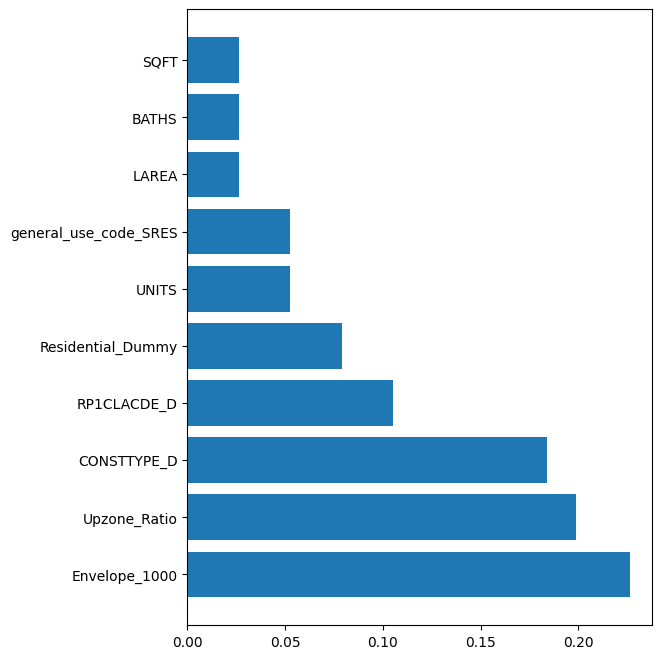

In [76]:
importances = rfc_best_outcome.best_estimator_.steps[0][1].feature_importances_
ft_imp = pd.Series(importances,
                   index=train_dummy_X.columns)
ft_imp = ft_imp.sort_values(ascending=False)
plt.figure(figsize=(6, 8))
plt.barh(ft_imp.index[:10], ft_imp[:10])
plt.show()

In [108]:
preds_class_rfc_or = rfc_best_outcome.predict(train_dummy_X)

In [109]:
print(classification_report(train_dummy['Developed'], preds_class_rfc_or, digits=5))


              precision    recall  f1-score   support

       False    0.99969   0.87334   0.93226    152927
        True    0.01078   0.83730   0.02128       252

    accuracy                        0.87329    153179
   macro avg    0.50523   0.85532   0.47677    153179
weighted avg    0.99807   0.87329   0.93076    153179



#### CatBoost

In [69]:
X_or = train.drop(['Developed', 'inInventory'], axis=1)
y_or = train['Developed']

categories = [X_or.columns[i] for i, d in enumerate(X_or.dtypes) if d == 'object']
X_or[categories] = X_or[categories].astype(str)

trainX_or, validX_or, trainY_or, validY_or = train_test_split(X_or, y_or, train_size=0.8, random_state=42)

train_dataset_or = Pool(data=trainX_or,
                        label=trainY_or,
                        cat_features = categories)

eval_dataset_or = Pool(data=validX_or,
                       label=validY_or, 
                       cat_features = categories)

train_pool_or = Pool(data=X_or, label=y_or, has_header=True, 
                     cat_features = categories)

In [70]:
def hyperopt_objective(params):

    model = CatBoostClassifier(**params, random_seed=42)
    model.fit(train_dataset_or, verbose=10, eval_set=eval_dataset_or, early_stopping_rounds=10)
    model.predict_proba(validX_or)
    cv_data = cv(
        params=params,
        pool=train_pool_or,
        fold_count=5,
        shuffle=True,
        partition_random_seed=0,
        stratified=False,
        verbose=False,
        early_stopping_rounds=10
    )
    
    loss = cv_data['test-Logloss-mean'].min()
    print(loss)
    return loss

# We initiate a Trial object to keep track of search results and we set a hyperparameter space
trials = Trials()

space = {
    "iterations": 100,
     "loss_function": "Logloss",
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'depth': hp.randint('depth', 3, 15),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 15),
    'border_count': hp.randint('border_count', 2, 50),
    'boosting_type': 'Plain'
}

best = fmin(hyperopt_objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            rstate=np.random.default_rng(42))

  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]0:	learn: 0.0639716	test: 0.0649849	best: 0.0649849 (0)	total: 72.8ms	remaining: 7.21s
10:	learn: 0.0066907	test: 0.0099973	best: 0.0099973 (10)	total: 754ms	remaining: 6.1s
20:	learn: 0.0055987	test: 0.0099022	best: 0.0098594 (18)	total: 1.41s	remaining: 5.32s
30:	learn: 0.0049009	test: 0.0099169	best: 0.0098256 (24)	total: 2.06s	remaining: 4.58s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.009825604774
bestIteration = 24

Shrink model to first 25 iterations.
Training on fold [0/5]

bestTest = 0.007670061009
bestIteration = 41

Training on fold [1/5]

bestTest = 0.009026589872
bestIteration = 85

Training on fold [2/5]

bestTest = 0.008062127386
bestIteration = 30

Training on fold [3/5]

bestTest = 0.008040127201
bestIteration = 60

Training on fold [4/5]

bestTest = 0.007527655059
bestIteration = 38

0.00810555721041878                        

Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.009622975324
bestIteration = 37

Shrink model to first 38 iterations.
Training on fold [0/5]

bestTest = 0.007630015266
bestIteration = 42

Training on fold [1/5]

bestTest = 0.00953051706
bestIteration = 61

Training on fold [2/5]

bestTest = 0.007886504708
bestIteration = 99

Training on fold [3/5]

bestTest = 0.008799212792
bestIteration = 39

Training on fold [4/5]

bestTest = 0.007720955705
bestIteration = 32

0.008322090187843561                                                                                                   
 70%|████████████████████████████████▉              | 7/10 [09:59<02:24, 48.26s/trial, best loss: 0.007822827036439942]0:	learn: 0.5566329	test: 0.5567907	best: 0.5567907 (0)	total: 69.6ms	remaining: 6.89s
10:	learn: 0.0762811	test: 0.0771338	best: 0.0771338 (10)	total: 583ms	remaining: 4.72s
20:	learn: 0.0228034	test: 0.0240280	best: 0.0240280 (20)	total: 1.09s	remaining: 4.11s
30:	learn: 

In [71]:
best

{'border_count': 22,
 'depth': 12,
 'l2_leaf_reg': 7.727800361957377,
 'learning_rate': 0.1692658724403825}

In [72]:
pickle.dump(trials, open("my_trials_outcomes.pkl", "wb"))

with open("my_trials_outcomes.pkl", "rb") as f:
    object = pickle.load(f)

df_trials = pd.DataFrame(object)
df_trials.to_csv(r'catboost_results_outcomes.csv')

In [73]:
catboostFinalOR = CatBoostClassifier(**best, loss_function='Logloss')

In [74]:
catboostFinalOR.fit(train_dataset_or)

0:	learn: 0.2818855	total: 428ms	remaining: 7m 8s
1:	learn: 0.1224207	total: 842ms	remaining: 7m
2:	learn: 0.0609203	total: 946ms	remaining: 5m 14s
3:	learn: 0.0337073	total: 1.4s	remaining: 5m 47s
4:	learn: 0.0212861	total: 1.85s	remaining: 6m 8s
5:	learn: 0.0159490	total: 2.33s	remaining: 6m 26s
6:	learn: 0.0129201	total: 2.76s	remaining: 6m 32s
7:	learn: 0.0111067	total: 3.2s	remaining: 6m 37s
8:	learn: 0.0097070	total: 3.65s	remaining: 6m 41s
9:	learn: 0.0089507	total: 4.11s	remaining: 6m 46s
10:	learn: 0.0083971	total: 4.54s	remaining: 6m 48s
11:	learn: 0.0080088	total: 5s	remaining: 6m 51s
12:	learn: 0.0076459	total: 5.43s	remaining: 6m 52s
13:	learn: 0.0074182	total: 5.86s	remaining: 6m 52s
14:	learn: 0.0073016	total: 6.32s	remaining: 6m 54s
15:	learn: 0.0071625	total: 6.78s	remaining: 6m 56s
16:	learn: 0.0069100	total: 7.26s	remaining: 7m
17:	learn: 0.0066922	total: 7.71s	remaining: 7m
18:	learn: 0.0064668	total: 8.19s	remaining: 7m 2s
19:	learn: 0.0063227	total: 8.65s	remainin

158:	learn: 0.0027843	total: 1m 10s	remaining: 6m 12s
159:	learn: 0.0027835	total: 1m 10s	remaining: 6m 12s
160:	learn: 0.0027827	total: 1m 11s	remaining: 6m 11s
161:	learn: 0.0027750	total: 1m 11s	remaining: 6m 11s
162:	learn: 0.0027663	total: 1m 12s	remaining: 6m 10s
163:	learn: 0.0027608	total: 1m 12s	remaining: 6m 10s
164:	learn: 0.0027549	total: 1m 13s	remaining: 6m 10s
165:	learn: 0.0027542	total: 1m 13s	remaining: 6m 9s
166:	learn: 0.0027468	total: 1m 14s	remaining: 6m 9s
167:	learn: 0.0027357	total: 1m 14s	remaining: 6m 8s
168:	learn: 0.0027313	total: 1m 14s	remaining: 6m 8s
169:	learn: 0.0027277	total: 1m 15s	remaining: 6m 8s
170:	learn: 0.0027071	total: 1m 15s	remaining: 6m 7s
171:	learn: 0.0027041	total: 1m 16s	remaining: 6m 7s
172:	learn: 0.0026738	total: 1m 16s	remaining: 6m 7s
173:	learn: 0.0026632	total: 1m 17s	remaining: 6m 6s
174:	learn: 0.0026556	total: 1m 17s	remaining: 6m 6s
175:	learn: 0.0026510	total: 1m 18s	remaining: 6m 6s
176:	learn: 0.0026265	total: 1m 18s	rem

311:	learn: 0.0014495	total: 2m 25s	remaining: 5m 19s
312:	learn: 0.0014434	total: 2m 25s	remaining: 5m 19s
313:	learn: 0.0014272	total: 2m 26s	remaining: 5m 19s
314:	learn: 0.0014139	total: 2m 26s	remaining: 5m 18s
315:	learn: 0.0014111	total: 2m 27s	remaining: 5m 18s
316:	learn: 0.0014080	total: 2m 27s	remaining: 5m 17s
317:	learn: 0.0014061	total: 2m 28s	remaining: 5m 17s
318:	learn: 0.0014011	total: 2m 28s	remaining: 5m 17s
319:	learn: 0.0013971	total: 2m 29s	remaining: 5m 16s
320:	learn: 0.0013961	total: 2m 29s	remaining: 5m 16s
321:	learn: 0.0013950	total: 2m 30s	remaining: 5m 16s
322:	learn: 0.0013941	total: 2m 30s	remaining: 5m 15s
323:	learn: 0.0013817	total: 2m 31s	remaining: 5m 15s
324:	learn: 0.0013763	total: 2m 31s	remaining: 5m 15s
325:	learn: 0.0013628	total: 2m 32s	remaining: 5m 14s
326:	learn: 0.0013605	total: 2m 32s	remaining: 5m 14s
327:	learn: 0.0013599	total: 2m 33s	remaining: 5m 13s
328:	learn: 0.0013516	total: 2m 33s	remaining: 5m 13s
329:	learn: 0.0013508	total:

464:	learn: 0.0009683	total: 3m 43s	remaining: 4m 17s
465:	learn: 0.0009678	total: 3m 44s	remaining: 4m 17s
466:	learn: 0.0009658	total: 3m 44s	remaining: 4m 16s
467:	learn: 0.0009650	total: 3m 45s	remaining: 4m 16s
468:	learn: 0.0009649	total: 3m 46s	remaining: 4m 15s
469:	learn: 0.0009646	total: 3m 46s	remaining: 4m 15s
470:	learn: 0.0009644	total: 3m 47s	remaining: 4m 15s
471:	learn: 0.0009644	total: 3m 47s	remaining: 4m 14s
472:	learn: 0.0009622	total: 3m 48s	remaining: 4m 14s
473:	learn: 0.0009605	total: 3m 48s	remaining: 4m 13s
474:	learn: 0.0009604	total: 3m 49s	remaining: 4m 13s
475:	learn: 0.0009603	total: 3m 49s	remaining: 4m 13s
476:	learn: 0.0009576	total: 3m 50s	remaining: 4m 12s
477:	learn: 0.0009553	total: 3m 50s	remaining: 4m 12s
478:	learn: 0.0009550	total: 3m 51s	remaining: 4m 11s
479:	learn: 0.0009547	total: 3m 52s	remaining: 4m 11s
480:	learn: 0.0009547	total: 3m 52s	remaining: 4m 10s
481:	learn: 0.0009537	total: 3m 53s	remaining: 4m 10s
482:	learn: 0.0009526	total:

618:	learn: 0.0007437	total: 5m 6s	remaining: 3m 8s
619:	learn: 0.0007421	total: 5m 7s	remaining: 3m 8s
620:	learn: 0.0007420	total: 5m 7s	remaining: 3m 7s
621:	learn: 0.0007384	total: 5m 8s	remaining: 3m 7s
622:	learn: 0.0007367	total: 5m 8s	remaining: 3m 6s
623:	learn: 0.0007360	total: 5m 9s	remaining: 3m 6s
624:	learn: 0.0007358	total: 5m 9s	remaining: 3m 5s
625:	learn: 0.0007356	total: 5m 10s	remaining: 3m 5s
626:	learn: 0.0007352	total: 5m 10s	remaining: 3m 4s
627:	learn: 0.0007350	total: 5m 11s	remaining: 3m 4s
628:	learn: 0.0007347	total: 5m 12s	remaining: 3m 4s
629:	learn: 0.0007345	total: 5m 12s	remaining: 3m 3s
630:	learn: 0.0007333	total: 5m 13s	remaining: 3m 3s
631:	learn: 0.0007323	total: 5m 13s	remaining: 3m 2s
632:	learn: 0.0007322	total: 5m 14s	remaining: 3m 2s
633:	learn: 0.0007292	total: 5m 14s	remaining: 3m 1s
634:	learn: 0.0007221	total: 5m 15s	remaining: 3m 1s
635:	learn: 0.0007206	total: 5m 16s	remaining: 3m
636:	learn: 0.0007205	total: 5m 16s	remaining: 3m
637:	l

772:	learn: 0.0006105	total: 6m 35s	remaining: 1m 56s
773:	learn: 0.0006104	total: 6m 35s	remaining: 1m 55s
774:	learn: 0.0006104	total: 6m 36s	remaining: 1m 55s
775:	learn: 0.0006103	total: 6m 36s	remaining: 1m 54s
776:	learn: 0.0006100	total: 6m 37s	remaining: 1m 54s
777:	learn: 0.0006066	total: 6m 38s	remaining: 1m 53s
778:	learn: 0.0006066	total: 6m 38s	remaining: 1m 53s
779:	learn: 0.0006054	total: 6m 39s	remaining: 1m 52s
780:	learn: 0.0006044	total: 6m 40s	remaining: 1m 52s
781:	learn: 0.0006036	total: 6m 40s	remaining: 1m 51s
782:	learn: 0.0006029	total: 6m 41s	remaining: 1m 51s
783:	learn: 0.0006022	total: 6m 41s	remaining: 1m 50s
784:	learn: 0.0006022	total: 6m 42s	remaining: 1m 50s
785:	learn: 0.0006016	total: 6m 43s	remaining: 1m 49s
786:	learn: 0.0005991	total: 6m 43s	remaining: 1m 49s
787:	learn: 0.0005980	total: 6m 44s	remaining: 1m 48s
788:	learn: 0.0005978	total: 6m 45s	remaining: 1m 48s
789:	learn: 0.0005978	total: 6m 45s	remaining: 1m 47s
790:	learn: 0.0005956	total:

926:	learn: 0.0004760	total: 8m 6s	remaining: 38.3s
927:	learn: 0.0004760	total: 8m 6s	remaining: 37.8s
928:	learn: 0.0004757	total: 8m 7s	remaining: 37.3s
929:	learn: 0.0004751	total: 8m 8s	remaining: 36.7s
930:	learn: 0.0004751	total: 8m 8s	remaining: 36.2s
931:	learn: 0.0004745	total: 8m 9s	remaining: 35.7s
932:	learn: 0.0004735	total: 8m 9s	remaining: 35.2s
933:	learn: 0.0004732	total: 8m 10s	remaining: 34.6s
934:	learn: 0.0004732	total: 8m 10s	remaining: 34.1s
935:	learn: 0.0004732	total: 8m 11s	remaining: 33.6s
936:	learn: 0.0004722	total: 8m 12s	remaining: 33.1s
937:	learn: 0.0004703	total: 8m 12s	remaining: 32.6s
938:	learn: 0.0004699	total: 8m 13s	remaining: 32.1s
939:	learn: 0.0004697	total: 8m 14s	remaining: 31.5s
940:	learn: 0.0004697	total: 8m 14s	remaining: 31s
941:	learn: 0.0004695	total: 8m 15s	remaining: 30.5s
942:	learn: 0.0004695	total: 8m 16s	remaining: 30s
943:	learn: 0.0004690	total: 8m 16s	remaining: 29.5s
944:	learn: 0.0004685	total: 8m 17s	remaining: 28.9s
945:

In [75]:
# Get predicted classes for training and validation set
preds_class_or = catboostFinalOR.predict(validX_or)
preds_class_train_or = catboostFinalOR.predict(trainX_or)


In [76]:
preds_class_train_or = [c == 'True' for c in preds_class_train_or]
preds_class_or = [c == 'True' for c in preds_class_or]

In [77]:
print(classification_report(validY_or, preds_class_or, digits=5))


              precision    recall  f1-score   support

       False    0.99817   0.99980   0.99899     30583
        True    0.25000   0.03448   0.06061        58

    accuracy                        0.99798     30641
   macro avg    0.62409   0.51714   0.52980     30641
weighted avg    0.99676   0.99798   0.99721     30641



In [78]:
%%time
explainer = shap.TreeExplainer(catboostFinalOR)
shap_values = explainer.shap_values(validX_or)

CPU times: total: 1h 37min 15s
Wall time: 9min 10s


In [79]:
plt.clf()
shap.summary_plot(shap_values,
                  validX_or,
                  feature_names=validX_or.columns,
                  color=my_cmap, 
                  max_display=10,
                  class_names=['Built', 'Not'],
                  show=False)  # show = False in order to save the figure properly
# plt.show()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./figures/shapleyvals_or.png', bbox_inches="tight")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [85]:
ftimp_or = pd.DataFrame({'feature_importance': catboostFinalOR.get_feature_importance(train_dataset_or), 
                         'feature_names': trainX_or.columns})

In [88]:
ftimp_or = ftimp_or.sort_values(by=['feature_importance'], ascending=False)

In [89]:
ftimp_or.head()

,feature_importance,feature_names
3,9.997439,Upzone_Ratio
48,7.499601,neighborhood
34,7.039482,LAREA
2,6.022568,Envelope_1000
44,5.993070,RP1LNDVAL


In [97]:
plt.clf()
ftimp_or.head(20).plot(kind='barh', x='feature_names', y='feature_importance')
plt.savefig('./figures/ftimp_or.png', bbox_inches="tight")